# Thall et al 2003

**Hierarchical Bayesian approaches to phase II trials in diseases with multiple subtypes**

Some important excerpts

![](2022-06-21-11-48-03.png)

![](2022-06-21-11-18-30.png)

![](2022-06-21-11-46-54.png)

In [1]:
import sys
sys.path.append('../imprint/research/berry/')
import berrylib.util as util
util.setup_nb()

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config
# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)

/Users/tbent/.mambaforge/envs/imprint/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checking the distributions are correct.

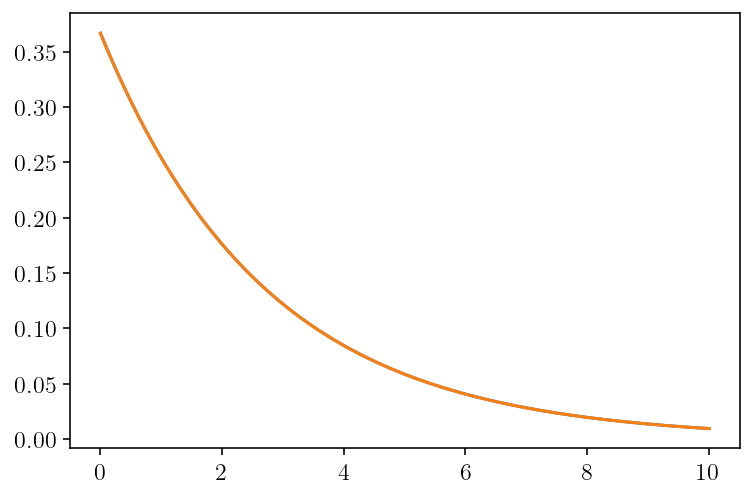

In [20]:
# Equivalence of scipy's exponential distribution and gamma distribution.
plt_vs = np.linspace(0.01, 10, 1000)
L = 1.0
rho = 1.0
mu_ttf = L * np.exp(rho)
hazard = 1.0 / mu_ttf
epdf = scipy.stats.expon.pdf(plt_vs, scale=mu_ttf)
gpdf = scipy.stats.gamma.pdf(plt_vs, 1.0, scale=mu_ttf)
plt.plot(plt_vs, epdf)
plt.plot(plt_vs, gpdf)
plt.show()

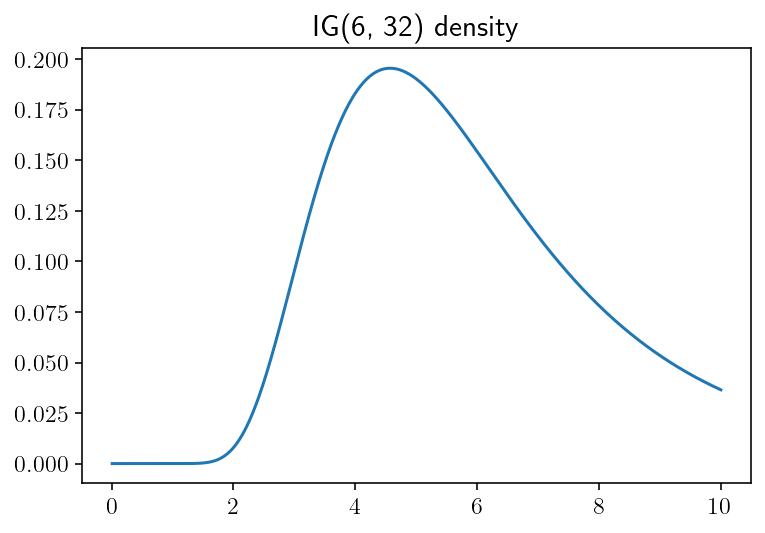

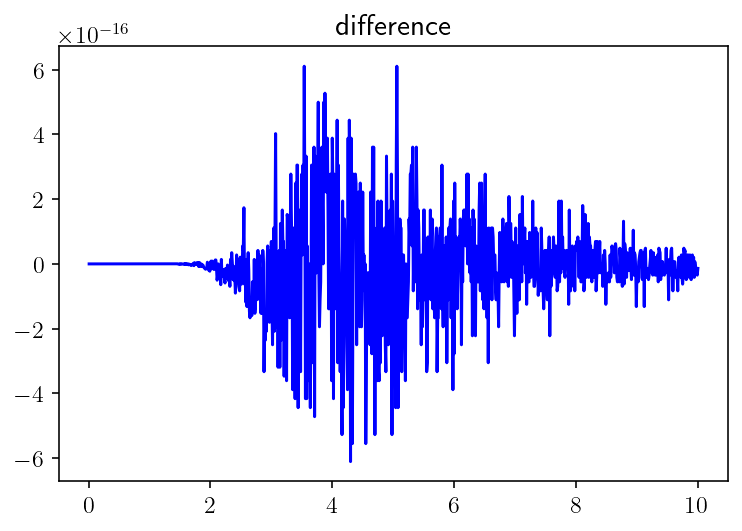

In [24]:
# Establishing the equivalence of scipy's invgamma and gamma pdfs.
alpha = 6
beta = 32
invgamma = scipy.stats.invgamma.pdf(plt_vs, alpha, scale=beta)
trans_gamma = scipy.stats.gamma.pdf(1.0 / plt_vs, alpha, scale=1.0 / beta) / (plt_vs ** 2)
plt.title(f'IG({alpha}, {beta}) density')
plt.plot(plt_vs, invgamma)
plt.show()
plt.title('difference')
plt.plot(plt_vs, trans_gamma - invgamma, 'b-')
plt.show()

## Setting up priors

mean, 95% ci
18.10, [12.06271817 27.07245591]
 5.09, [3.99527636 6.48455131]
 6.00, [4.38906768 8.18852176]


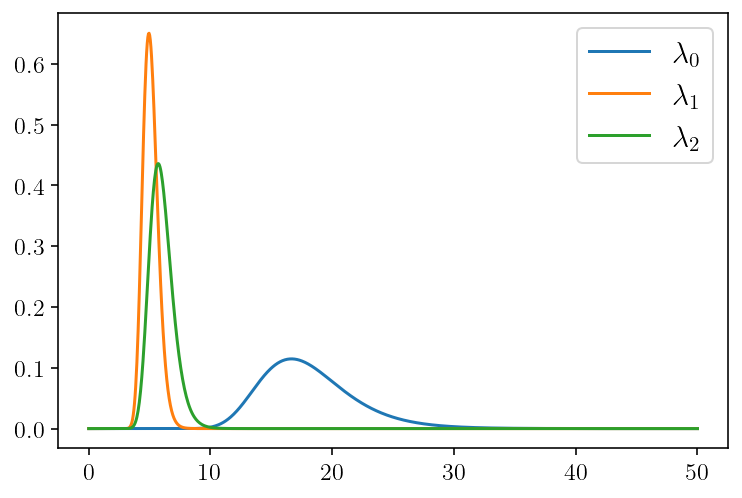

In [41]:
# Priors on lambda_j
# Check that they have the same mean and 95% CI as described in Table II of the paper.
alpha = [24, 66, 40]
beta = [416.3, 331, 234]
plt_vs = np.linspace(0, 50, 1000)
print('mean, 95% ci')
for j in range(3):
    pdf = scipy.stats.invgamma.pdf(plt_vs, alpha[j], scale=beta[j])
    plt.plot(plt_vs, pdf, label=f'$\lambda_{j}$')
    plt_vs = np.linspace(0, 50, 1000)
    mean= scipy.stats.invgamma.mean(alpha[j], scale=beta[j])
    ci = scipy.stats.invgamma.ppf([0.025, 0.975], alpha[j], scale=beta[j])
    print(f'{mean:5.2f}, {ci}')
plt.legend()
plt.show()

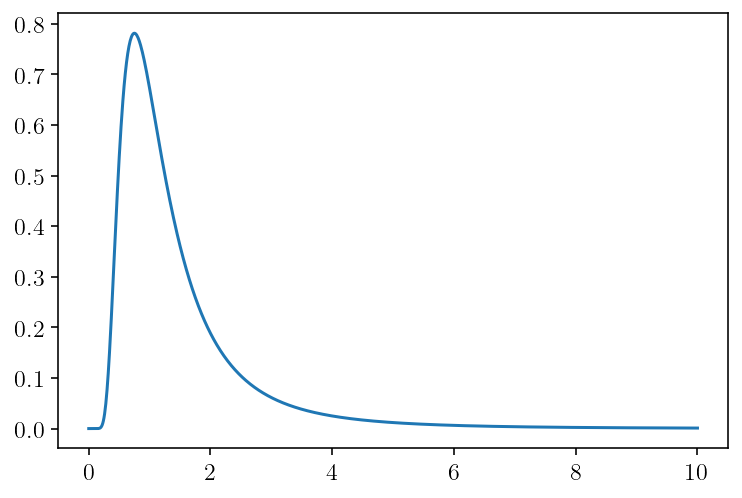

In [128]:
# Priors on rho_j
mu_mean = 0.1856
mu_sig2 = 1.0 / 0.5
sig2_alpha = 3.0
sig2_beta = 3.0

sig2_dist = scipy.stats.invgamma(sig2_alpha, scale=sig2_beta)

plt_vs = np.linspace(0, 10, 1000)
pdf = sig2_dist.pdf(plt_vs)
plt.plot(plt_vs, pdf)
plt.show()

In [79]:
# What is the support of the prior? (Much nicer than the Berry prior!)
sig2_dist.ppf([0.0000001, 0.999, 0.99999])

array([ 0.1384474 , 15.74527276, 75.87797471])

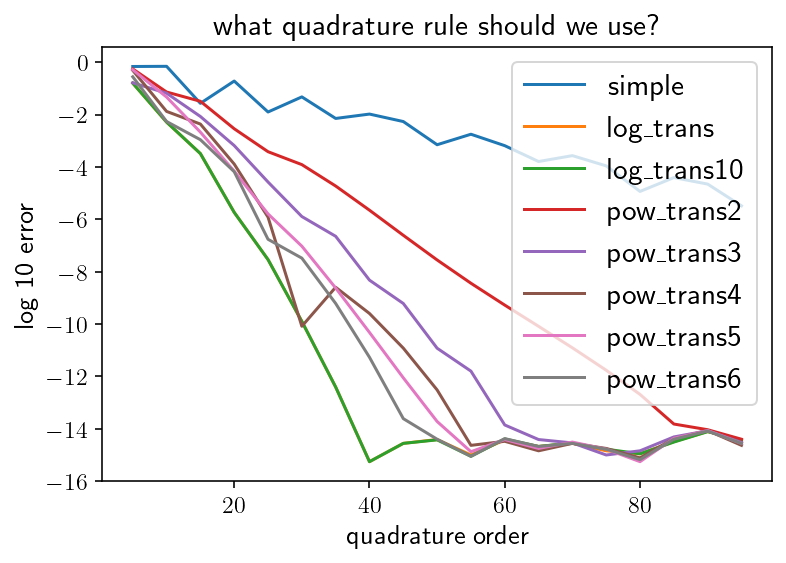

In [121]:
left = 0.05
pp = 0.99999
right = sig2_dist.ppf(pp)


def pow_gauss_rule(N, a, b, pow):
    A = (a) ** (1.0 / pow)
    B = (b) ** (1.0 / pow)
    qr = util.gauss_rule(N, a=A, b=B)
    pts = qr.pts**pow
    wts = pow * qr.pts ** (pow - 1) * qr.wts
    return util.QuadRule(pts, wts)


rules = dict(
    simple=util.gauss_rule,
    log_trans=util.log_gauss_rule,
    log_trans10=lambda N, a, b: util.log_gauss_rule(N, a, b, 10.0),
)
for pow in [2, 3, 4, 5, 6]:
    rules[f'pow_trans{pow}'] = lambda N, a, b, pow=pow: pow_gauss_rule(N, a, b, pow)
orders = np.arange(5, 100, 5)
err = {k: [] for k in rules}
for i in orders:
    for k in rules:
        qr = rules[k](i, left, right)
        pdf = sig2_dist.pdf(qr.pts)
        quad = np.sum(pdf * qr.wts)
        err[k].append(quad - pp)

for k in rules:
    plt.plot(orders, np.log10(np.abs(err[k])), label=k)
plt.legend()
plt.title('what quadrature rule should we use?')
plt.ylabel('log 10 error')
plt.xlabel('quadrature order')
plt.show()

In [116]:
# 15 points with the log transformation should probably be good enough but we might consider 20 points.
orders[2], err['log_trans'][2], orders[3], err['log_trans'][3]

(15, -0.0003233903478698785, 20, -1.840634887728676e-06)

In [143]:
qr_sigma2 = util.log_gauss_rule(20, 0.05, 75)

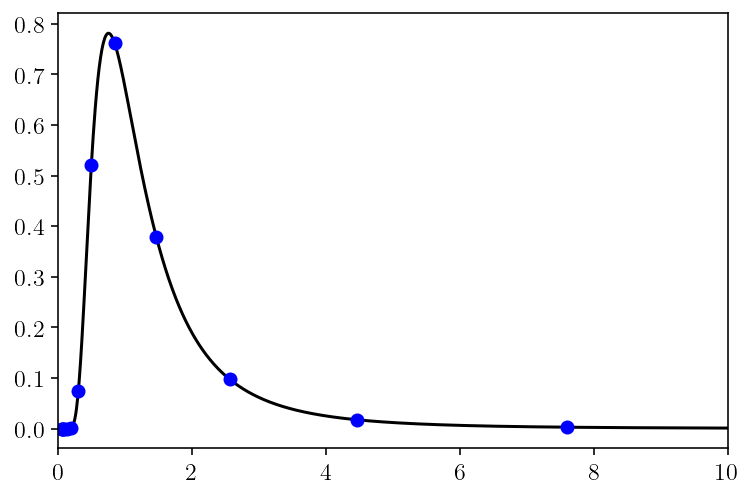

In [144]:
# But the distribution of points is still pretty obviously suboptimal, with too
# many points out in the two tails and too few points in the steep area.
plt_vs = np.linspace(0, 10, 1000)
pdf = sig2_dist.pdf(plt_vs)
plt.plot(plt_vs, pdf, 'k')
plt.plot(qr_sigma2.pts, sig2_dist.pdf(qr_sigma2.pts), 'bo')
plt.xlim([0, 10])
plt.show()

**I could design optimal quadrature rule for the known prior?!**

In [145]:
mu_mean, mu_sig2, qr_sigma2.pts

(0.1856,
 2.0,
 array([5.12722177e-02, 5.70406187e-02, 6.89200743e-02, 9.00449983e-02,
        1.26417300e-01, 1.89205330e-01, 2.99044297e-01, 4.93802533e-01,
        8.41940321e-01, 1.46382118e+00, 2.56178832e+00, 4.45399740e+00,
        7.59412873e+00, 1.25399482e+01, 1.98197377e+01, 2.96636615e+01,
        4.16458445e+01, 5.44108525e+01, 6.57426249e+01, 7.31390248e+01]))

In [146]:
np.sqrt(mu_sig2 + qr_sigma2.pts[None, :])

array([[1.43222632, 1.43423869, 1.43837411, 1.44569879, 1.45822402,
        1.47959634, 1.51625997, 1.5791778 , 1.68580554, 1.86113438,
        2.13583434, 2.54047189, 3.09743906, 3.8131284 , 4.6711602 ,
        5.62704731, 6.60650017, 7.51071585, 8.2305908 , 8.66827692]])

In [147]:
(sig2_dist.pdf(qr_sigma2.pts) * qr_sigma2.wts)

array([2.50336623e-22, 1.55622974e-19, 1.17810148e-15, 1.91121257e-11,
       1.23050631e-07, 1.11976674e-04, 1.06888237e-02, 1.33925760e-01,
       3.49769147e-01, 3.09658338e-01, 1.39056083e-01, 4.24944989e-02,
       1.07893724e-02, 2.59522419e-03, 6.44138785e-04, 1.74228353e-04,
       5.29585762e-05, 1.81754195e-05, 6.73898828e-06, 2.13309066e-06])

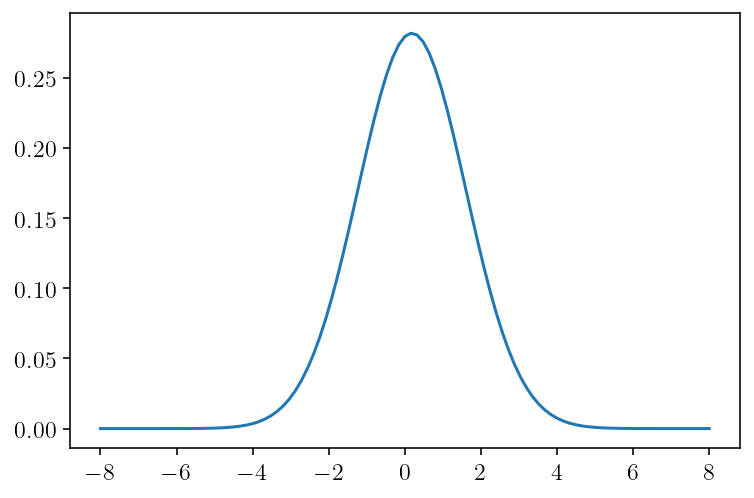

In [159]:
mu_qr = util.simpson_rule(101, -8, 8)
mu_vs = mu_qr.pts
pdf = scipy.stats.norm.pdf(mu_vs[:, None], mu_mean, np.sqrt(mu_sig2 + qr_sigma2.pts[None, :]))
pdf = np.sum(pdf * (sig2_dist.pdf(qr_sigma2.pts) * qr_sigma2.wts)[None], axis=1)
pdf = scipy.stats.norm.pdf(mu_vs[:, None], mu_mean, np.sqrt(mu_sig2))
plt.plot(mu_vs, pdf)
plt.show()

In [164]:
mu_mean

0.1856

In [163]:
(mu_vs * pdf * mu_qr.wts).sum()

1.454912579301748e-14

In [160]:
np.exp((mu_vs * pdf * mu_qr.wts).sum())

1.0000000000000147